In [1]:
%matplotlib inline
import pandas as pd
import re
import os, glob
import requests, zipfile
import geopandas as gpd
import sqlite3
from shapely.geometry import Point
import json
from osmxtract import overpass
import geojson

# Download borders from ISTAT to identify the areas of Rovereto and Trento

In [5]:
geoistat = 'geoistat'
confiniamministrativi = 'http://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012019.zip'
zipconfini = 'Limiti01012019.zip' 
if not os.path.exists(geoistat):
    os.mkdir(geoistat)
os.chdir(geoistat)
r = requests.get(confiniamministrativi, allow_redirects=True)
open(zipconfini, 'wb').write(r.content)

64959243

In [6]:
zipconfini = 'Limiti01012019.zip' 

In [7]:
zip_ref = zipfile.ZipFile(zipconfini, 'r')
zip_ref.extractall()
zip_ref.close()

In [2]:
limiti_comuni = gpd.read_file('Limiti01012019' + os.sep + 'Com01012019' + os.sep + 'Com01012019_WGS84.shp',driver='ESRI Shapefile')

## Show the borders

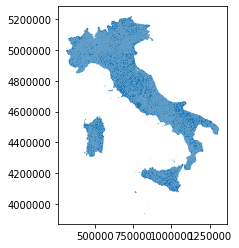

In [3]:
limiti_comuni.plot()

## Filter the data for Rovereto and Trento

In [4]:
trento_rovereto_confini = limiti_comuni[(limiti_comuni.COMUNE == 'Rovereto') | (limiti_comuni.COMUNE == 'Trento')]

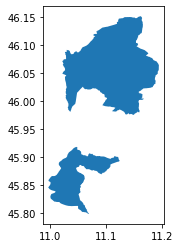

In [5]:
trento_rovereto_confini.to_crs({'init': 'epsg:4326'}).plot()

# Download all the TMC data from CCISS

In [16]:
tmcurls = {}
tmcurls['tmc_db_20']='https://www.cciss.it/documents/20926/54818/Datex+2.0/8dc364a6-3665-4feb-b79d-094a4f9a6d46'
tmcurls['tmc_db_21']='https://www.cciss.it/documents/20926/54818/Datex+2.1/a761f8c4-5426-4214-bed6-c2755b890d18'
tmcurls['tmc_db_22']='https://www.cciss.it/documents/20926/54818/Datex+2.2/9078c71e-021f-48e6-af5e-96bfefbd5aea'
tmcurls['tmc_db_31']='https://www.cciss.it/documents/20926/54818/Datex+3.1/c1c3777b-9fad-4bc2-a85c-aabd5b7c48bb'
tmcurls['tmc_db_33']='https://www.cciss.it/documents/20926/54818/Datex+3.3/78e37b79-c012-4843-9a36-e247378c7bf2'
tmcurls['tmc_db_41']='https://www.cciss.it/documents/20926/54818/Datex+4.1/da8fbb73-f2d8-463e-827c-0822ef45df23'
tmcurls['tmc_db_43']='https://www.cciss.it/documents/20926/54818/Datex+4.3/01f08f30-36b6-4d4c-9931-b6792afc0d29'
tmcurls['tmc_db_45']='https://www.cciss.it/documents/20926/54818/Database+RDS-TMC+4.5/9e627493-7bd6-4cd1-8ec4-b8989d6b11b2'

In [103]:
#function to create the coordinates
# ATTENTION: some TMC are without coordinates, in this case we assume lat=0 and lon=0
def createPoint(value):
    value = str(value)
    value = re.findall(r'\d+', value)
    if len(value) > 0:
        v = float(value[0])/100000
    else:
        v = 0
    return(v)

## Download all the TMC data

In [18]:
tmc_datasets = []
for key in tmcurls.keys():
    tmc_data = key
    urltmc = tmcurls[key]
    fileziptmc = key + '.zip'
    if not os.path.exists(tmc_data):
        os.mkdir(tmc_data)
    os.chdir(tmc_data)
    r = requests.get(urltmc, allow_redirects=True)
    open(fileziptmc, 'wb').write(r.content)
    zip_ref = zipfile.ZipFile(fileziptmc, 'r')
    zip_ref.extractall()
    zip_ref.close()
    datasets = {}
    files = glob.glob("*.DAT")
    if len(files) == 0:
        files = glob.glob("*.dat")
    for file in files:
        namef = file.lower().replace(".dat","")
        df = pd.read_csv(file,sep=";",encoding='iso-8859-1')
        datasets[namef]=df
    df = datasets['points']
    df['LON'] = df.XCOORD.apply(lambda x: createPoint(x))
    df['LAT'] = df.YCOORD.apply(lambda x: createPoint(x))
    #df = df.drop(['XCOORD', 'YCOORD'], axis=1)
    datasets['points'] = df
    conn = sqlite3.connect(tmc_data + ".sqlite")
    for dataset in datasets.keys():
        df = datasets[dataset]
        df.to_sql(dataset, conn, if_exists="replace")
    tmc_datasets.append(datasets)

/home/napo/Desktop/Data_Rovereto_2018/env/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)
/home/napo/Desktop/Data_Rovereto_2018/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### note
* each zip contains a file in a csv format with extesion .data
* each files is transformed in a dataframe
* the collection of the dataframes is storend in the dictinari _tmc_datasets_ with key the name of the zip
* each zip is also transformed in a .sqlite file with a table for each files

### collect all the TMC points in a geodataframe

In [104]:
all_points= pd.DataFrame()
for datasets in tmc_datasets:
    df = datasets['points']
    geometry = [Point(xy) for xy in zip(df.LON, df.LAT)]
    crs = {'init': 'epsg:4326'}
    points = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    if all_points.isna:
        all_points = points
    else:
        all_points = pd.concat([all_points,points])

In [105]:
all_points.shape

(37257, 30)

In [106]:
all_points

,CID,TABCD,LCD,CLASS,TCD,STCD,JUNCTIONNUMBER,RNID,N1ID,N2ID,...,DIVERSIONPOS,DIVERSIONNEG,XCOORD,YCOORD,INTERRUPTSROAD,URBAN,JNID,LON,LAT,geometry
0,25,1,11938,P,1,11,NaN,24768.0,3836,NaN,...,NaN,NaN,1266945,4179301,NaN,0,NaN,12.66945,41.79301,POINT (12.66945 41.79301)
1,25,1,29707,P,1,11,NaN,25158.0,41924,NaN,...,NaN,NaN,901243,4501103,NaN,0,NaN,9.01243,45.01103,POINT (9.01243 45.01103)
2,25,1,17386,P,1,11,NaN,NaN,30404,NaN,...,NaN,NaN,1508059,4132977,NaN,0,NaN,15.08059,41.32977,POINT (15.08059 41.32977)
3,25,1,22422,P,1,11,NaN,NaN,12604,NaN,...,NaN,NaN,1540367,4143061,NaN,0,NaN,15.40367,41.43061,POINT (15.40367 41.43061)
4,25,1,13886,P,1,11,NaN,47778.0,28076,NaN,...,NaN,NaN,864800,4541994,NaN,0,NaN,8.64800,45.41994,POINT (8.648 45.41994)
5,25,1,16578,P,1,11,NaN,NaN,41320,NaN,...,NaN,NaN,1481107,4095755,NaN,0,NaN,14.81107,40.95755,POINT (14.81107 40.95755)
6,25,1,23255,P,1,11,NaN,46428.0,47436,NaN,...,NaN,NaN,888403,4451052,NaN,0,NaN,8.88403,44.51052,POINT (8.884029999999999 44.51052)
7,25,1,45312,P,1,11,NaN,39782.0,56732,NaN,...,NaN,NaN,1288754,4183362,NaN,0,NaN,12.88754,41.83362,POINT (12.88754 41.83362)
8,25,1,14727,P,1,11,NaN,NaN,74750,NaN,...,NaN,NaN,885944,4472077,NaN,0,NaN,8.85944,44.72077,POINT (8.859439999999999 44.72077)
9,25,1,2884,P,1,11,NaN,53798.0,44018,NaN,...,NaN,NaN,1010862,4403717,NaN,0,NaN,10.10862,44.03717,POINT (10.10862 44.03717)


### Find all the points inside the border of Rovereto and Trento

In [107]:
tmcpoints_trento_rovereto = gpd.sjoin(trento_rovereto_confini.to_crs({'init': 'epsg:4326'}),all_points, how='inner', op='contains', lsuffix='left', rsuffix='right')

In [25]:
confini = trento_rovereto_confini.to_crs({'init': 'epsg:4326'}).reset_index()

In [26]:
points_in_confini = gpd.sjoin(all_points, confini, op="within")

We have 59 points inside the borders!!!

In [27]:
points_in_confini.shape

(59, 44)

In [28]:
points_in_confini

,CID,TABCD,LCD,CLASS,TCD,STCD,JUNCTIONNUMBER,RNID,N1ID,N2ID,...,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,Shape_Area
201,25,1,36485,P,1,11,NaN,NaN,46334,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
799,25,1,36481,P,1,11,NaN,NaN,76640,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
2058,25,1,36512,P,1,11,NaN,NaN,4250,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
2157,25,1,45425,P,1,11,NaN,42390.0,3230,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
2370,25,1,4050,P,1,11,NaN,42390.0,35852,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
2797,25,1,4046,P,1,11,NaN,42390.0,31446,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
3322,25,1,36482,P,1,11,NaN,NaN,24244,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
4467,25,1,36483,P,1,11,NaN,NaN,57408,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
4661,25,1,45414,P,1,11,NaN,21868.0,20204,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08
5376,25,1,36400,P,1,11,NaN,NaN,46836,NaN,...,22,0,22,22205,022205,Trento,None,1,75408.030400,1.578748e+08


### Plot the pointis inside the borders

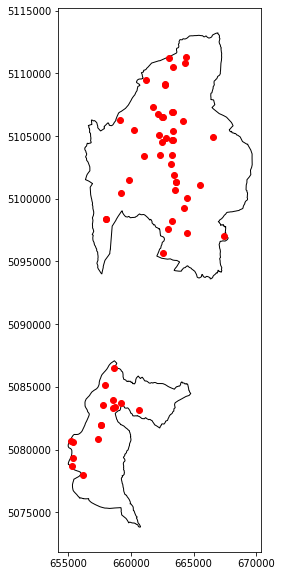

In [30]:
ax = confini.to_crs({'init': 'epsg:32632'}).plot(edgecolor='k', facecolor='none', figsize=(15, 10))
points_in_confini.to_crs({'init': 'epsg:32632'}).plot(ax=ax,color="red")

### plot with a background

In [109]:
import contextily as ctx

In [110]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [111]:
all_points_webmercator = all_points.to_crs(epsg=3857)

KeyboardInterrupt: 

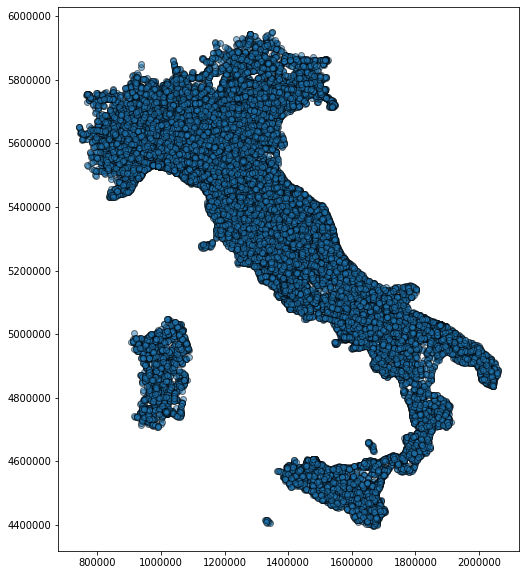

In [113]:
ax = all_points_webmercator.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
add_basemap(ax, zoom=10)

### export dafa in shapefile

In [31]:
all_points.to_file('all_tmc_points.shp',driver='ESRI Shapefile')

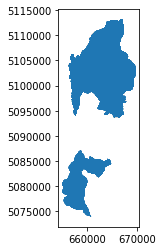

In [32]:
tmcpoints_trento_rovereto.to_crs({'init': 'epsg:32632'}).plot()

In [33]:
trento_rovereto_confini.to_crs({'init': 'epsg:4326'}).to_file("trento_rovereto.shp",driver='ESRI Shapefile')

In [34]:
points.to_file('tmc_points.shp',driver='ESRI Shapefile')

## Identify OSM trucks touched by the TMC Points
the case of Rovereto


In [ ]:
# recover bounds of Rovereto
bounds_rovereto=confini[confini.COMUNE=='Rovereto'].bounds

In [39]:
bounds = ( bounds_rovereto.miny[1], bounds_rovereto.minx[1], bounds_rovereto.maxy[1],bounds_rovereto.maxx[1])

In [ ]:
# extract all the highway in the boundng box of Rovereto by using Overpass-api

In [40]:
query = overpass.ql_query( bounds, tag='highway')

In [41]:
response = overpass.request(query)

In [42]:
feature_collection = overpass.as_geojson(response, 'linestring')

In [43]:
# I need to change this method of osmextract because i need also the osm_id

In [44]:
def _as_linestrings(elements):
    """Parse an iterable of elements to retrieve a FeatureCollection of linestrings.
    Parameters
    ----------
    elements : list of dict
        JSON response elements.
    Returns
    -------
    feature_collection : dict
        Output GeoJSON FeatureCollection.
    """
    features = []
    elements = [e for e in elements if e.get('type') == 'way']
    for elem in elements:
        coords = [[node['lon'], node['lat']] for node in elem['geometry']]
        geom = geojson.LineString(coordinates=coords)
        elem['tags']['osm_id']=elem['id']
        features.append(geojson.Feature(elem['id'], geom, elem['tags']))
    return geojson.FeatureCollection(features)

In [45]:
feature_collection = _as_linestrings(response['elements'])

In [46]:
highways_rovereto = gpd.GeoDataFrame.from_features(feature_collection)

In [47]:
highways_rovereto.crs = {'init' :'epsg:4326'}

In [ ]:
# I transform the points in 32632 to have the projection in meters

In [60]:
points_buffer_confini = points_in_confini.to_crs({'init': 'epsg:32632'})

#### this operation create circle with 10 meters of diameter (5 meter of radius)

In [ ]:
points_buffer_confini['geometry'] = points_buffer_confini.geometry.buffer(5)

In [62]:
# operation needed to clean 
points_buffer_confini.rename(columns={'index_right': 'indexright'}, inplace = True)

## spatial join to with the roads intersected by the TMC point in a radius of 5 meters

In [63]:
roads_osm_touched_tmc = gpd.sjoin(points_buffer_confini, highways_rovereto.to_crs({'init': 'epsg:32632'}), op='intersects')

##### selection of some columns

In [93]:
colums_to_show = ['osm_id','highway','name','ref']

In [94]:
for c in all_points.columns[0:10]:
    colums_to_show.append(c)

In [95]:
colums_to_show

['osm_id',
 'highway',
 'name',
 'ref',
 'CID',
 'TABCD',
 'LCD',
 'CLASS',
 'TCD',
 'STCD',
 'JUNCTIONNUMBER',
 'RNID',
 'N1ID',
 'N2ID']

In [96]:
roads_osm_touched_tmc[colums_to_show]

,osm_id,highway,name,ref,CID,TABCD,LCD,CLASS,TCD,STCD,JUNCTIONNUMBER,RNID,N1ID,N2ID
1537,24210574,primary,NaN,SS12,25,1,4040,P,1,11,NaN,42390.0,76678,NaN
7087,24210574,primary,NaN,SS12,25,1,45458,P,1,11,NaN,41746.0,45566,NaN
7087,52774260,primary,NaN,SS12,25,1,45458,P,1,11,NaN,41746.0,45566,NaN
8602,24855983,tertiary_link,NaN,NaN,25,1,45485,P,1,11,NaN,42390.0,602,NaN
8602,126234025,primary,Via Nazionale del Brennero,SS12,25,1,45485,P,1,11,NaN,42390.0,602,NaN
14035,225777284,tertiary,Via Schio,NaN,25,1,36387,P,1,11,NaN,NaN,34480,NaN
14035,148847020,tertiary,Via Santa Maria,NaN,25,1,36387,P,1,11,NaN,NaN,34480,NaN
14035,27034836,residential,Via Santa Maria,NaN,25,1,36387,P,1,11,NaN,NaN,34480,NaN
20269,24814831,primary,Strada Statale 12 del Brennero,SS12,25,1,4041,P,1,11,NaN,42390.0,72434,NaN
20269,512936824,cycleway,Pista Ciclo Pedonale,NaN,25,1,4041,P,1,11,NaN,42390.0,72434,NaN


In [100]:
df = datasets['names']

In [ ]:
df[df.NID==49092]